<a href="https://colab.research.google.com/github/DL-ECE/tp-1-deeplearningbasics-Geoffrey-FT/blob/master/Squad_TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP3: Question Answering using Bert 

In [1]:
!pip install transformers datasets ipywidgets matplotlib seaborn

     |████████████████████████████████| 1.3MB 13.7MB/s 
     |████████████████████████████████| 163kB 53.3MB/s 
     |████████████████████████████████| 2.9MB 47.0MB/s 
     |████████████████████████████████| 1.1MB 54.7MB/s 
     |████████████████████████████████| 890kB 53.2MB/s 
     |████████████████████████████████| 17.7MB 210kB/s 
     |████████████████████████████████| 245kB 55.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=9921c0dd9832e8c90da9136605b13f4157bc961b744e25ce19c194e99ea1ccca
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [2]:
import torch
from datasets import load_dataset
from transformers import RobertaTokenizer, RobertaForQuestionAnswering
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import RobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from typing import Tuple, List
from tqdm import tqdm
import seaborn as sns

# Intro
First have a look at the Bert/RoBerta original paper and Squad dataset:

https://arxiv.org/pdf/1810.04805.pdf

https://arxiv.org/pdf/1907.11692.pdf

https://rajpurkar.github.io/SQuAD-explorer/

# Dataset loading

In [3]:
squad_dataset = load_dataset('squad')
train_squad_dataset = squad_dataset["train"]
valid_squad_dataset = squad_dataset["validation"]
print("This is a Squad example:")
squad_dataset["train"][0]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/1244d044b266a5e4dbd4174d23cb995eead372fbca31a03edc3f8a132787af41. Subsequent calls will reuse this data.
This is a Squad example:


{'answers': {'answer_start': [515], 'text': ['Saint Bernadette Soubirous']},
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'id': '5733be284776f41900661182',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'title': 'University_of_Notre_Dame'}

In [4]:
#squad_dataset["train"][0]["context"]

# tokenizer import

In [5]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [6]:
# TODO: Comment the outputs of this line:
example = ["Hello world", "This is me the boss"]
tokenizer.batch_encode_plus(example, padding=True)

{'input_ids': [[0, 31414, 232, 2, 1, 1, 1], [0, 713, 16, 162, 5, 3504, 2]], 'attention_mask': [[1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1]]}

Write your comment here:

Attention_mask takes the length of the longest char + 2 (here it's 5 + 2 = 7) and the 2 extra slot are for the sep and cls token (0 and 2).
If the second char is shorter, for every less word you have 1s encoded in input_ids and 0s encoded in the attention_mask.

# Data preparation

In [7]:
def get_context(squad_example) -> Tuple[str,str,str]:
    # given a Squad example return three strings: left context, answer, righ context
    # the concatenation of these 3 str should be the squad_example["context"]
    context = squad_example["context"] # TODO
    answer = squad_example["answers"]["text"][0] # TODO
    answer_start = squad_example["answers"]["answer_start"][0] # TODO

    left_context = squad_example["context"][:answer_start] # TODO
    answer = answer # TODO
    right_context = squad_example["context"][(answer_start + len(answer)):] # TODO
    

    return left_context, answer, right_context


In [8]:
#get_context(squad_dataset["train"][0])

Deep learning models deal with number. 

The Bert model will take numbers (token ids)  as input. Thus, we need to tokenize the strings.

The format should be `[CLS token] question_token_ids [SEP token] [SEP token] context [SEP token]`

see https://huggingface.co/transformers/model_doc/roberta.html#robertatokenizer for more details

We also want the function to return the index of the token corresponding to the first token of the START word AND the index of the token corresponding to the last token of the END word.

In [9]:
def format_bert_input_and_labels(question:str, \
                                 left_context:str, \
                                 answer:str, \
                                 right_context:str, \
                                 tokenizer,
                                 context)-> Tuple[List[int], Tuple[int,int]]:

    true_context = tokenizer.encode(context, add_special_tokens=False)
    answer_prefix = " " if left_context and left_context[-1] == " " else ""
    sep_token_id = tokenizer.sep_token_id # TODO
    cls_token_id = tokenizer.cls_token_id # TODO
    
    question_ids = tokenizer.encode(question, add_special_tokens=False) # TODO
    left_context_ids = tokenizer.encode(left_context.strip(" "), add_special_tokens=False) # TODO
    answer_ids = tokenizer.encode(answer_prefix+answer, add_special_tokens=False) # TODO
    right_context_ids = tokenizer.encode(right_context, add_special_tokens=False) # TODO
    context_ids = left_context_ids + answer_ids + right_context_ids
    if true_context != context_ids:
       return None, None
    
    input_ids = [cls_token_id] + question_ids + [sep_token_id, sep_token_id] + context_ids + [sep_token_id] # TODO
    start_ids = len([cls_token_id] + question_ids + [sep_token_id, sep_token_id] + left_context_ids) # TODO
    end_ids = start_ids + len(answer_ids) - 1 # TODO
    return input_ids, (start_ids, end_ids)

In [10]:
#example = ["Hello Word","Coucou", "Salut"]
#l = tokenizer.encode(example, add_special_tokens=False)
#print(l)


Test your functions (the following cell should print the answer)

In [11]:
example_id = 34
context = squad_dataset["train"][example_id]["context"]
lc, a, rc = get_context(squad_dataset["train"][example_id])
ids, start_end_ids = format_bert_input_and_labels(squad_dataset["train"][example_id]['question'], lc, a, rc, tokenizer, context)
tokenizer.decode(ids[start_end_ids[0]:start_end_ids[1]+1])

' 14'

Now, we have to apply the two previous function to all the dataset:

In [12]:
def get_squad_examples(dataset):
    # This function should return all formated input ids as well as
    # all start/end indexes
    all_ids = []
    all_start_end_ids = []
    for squad_example in tqdm(dataset):
            context = squad_example["context"]
            lc, a, rc = get_context(squad_example)
            ids, start_end_ids = format_bert_input_and_labels(squad_example['question'], lc, a, rc, tokenizer, context)
            if ids is not None: #We need to exclude the none resuts of the function format_bert_input_and_labels when there is a special character like %
                all_ids.append(ids)
                all_start_end_ids.append(start_end_ids)

        
    return all_ids, all_start_end_ids

all_ids_train, all_start_end_ids_train = get_squad_examples(train_squad_dataset)
all_ids_valid, all_start_end_ids_valid = get_squad_examples(valid_squad_dataset)

100%|██████████| 10570/10570 [00:21<00:00, 503.20it/s]


In [13]:
#tqdm(train_squad_dataset)

In [14]:
#print(squad_dataset.shape["train"][0])
#print(train_squad_dataset.shape[0])
#train_squad_dataset[0]["context"]

# Dataset analysis
Display the distribution of the lengths of `all_ids_train` using the seaborn library

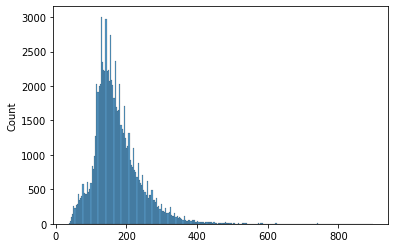

In [15]:
# TODO
distribution=[]
for id in all_ids_train: #we put all the ids in a list
    distribution.append(len(id))

sns.histplot(distribution) #we plot a histogram




In [16]:
#len(all_ids_train[0])

# Padding and filtering
The inputs contained in `all_ids_train` have different `len`. Since our model deals with tensors, we have to add pad_token (this token is provided by the tokenizer).

This way, all inputs will have the same `len` (which corresponds to the max_seq_len that we will define).

Assuming max_seq_len is set to *8* and `pad_token_id=123`, this transformation should append:

`[542, 642, 48301] -> [542, 642, 48301, 123, 123 ,123 ,123, 123]`


Examples with a `len` > `max_seq_len` should also be dropped.

In [17]:
def filter_and_pad_ids(all_ids: List[List[int]], \
                       all_start_end_ids:List[Tuple[int,int]], \
                       max_seq_len: int, \
                       tokenizer):
    
    assert max_seq_len <= 512
    pad_token_id = tokenizer.pad_token_id # TODO
    
    all_ids_filtered = []
    all_start_end_ids_filtered = []
    for ids, start_end_ids in zip(all_ids, all_start_end_ids):
        if len(ids) <= max_seq_len: # TODO: Write the appropriate condition
            n_pad_to_add = max_seq_len - len(ids) # TODO
            padded_ids = ids + [pad_token_id]*n_pad_to_add
            all_ids_filtered.append(padded_ids)
            all_start_end_ids_filtered.append(start_end_ids) # TODO
       
        
    assert len(all_ids_filtered) == len(all_start_end_ids_filtered) 
    return all_ids_filtered, all_start_end_ids_filtered

In [18]:
#l=[]
#for i in range (0,6): l.append(1)
#print(l)
#l.pop(l[1])
#print(l)

Choose a value for `max_seq_len` and explain you choice:

In [19]:
max_seq_len = 400 # TODO We noticed in the distribution we ploted earlier that after 400 there are not a lot of ids_train

all_ids_filtered_train, all_start_end_ids_filtered_train = filter_and_pad_ids(all_ids_train, \
                                                                              all_start_end_ids_train, \
                                                                              max_seq_len, \
                                                                              tokenizer)

all_ids_filtered_valid, all_start_end_ids_filtered_valid = filter_and_pad_ids(all_ids_valid, \
                                                                              all_start_end_ids_valid, \
                                                                              max_seq_len, \
                                                                              tokenizer)

Now let's turn our variables into tensors the model can handle:

In [20]:
def get_dataloader(all_ids_filtered, all_start_end_ids_filtered, pad_token_id:int, batch_size=24):
    batch_size = batch_size
    # get all start_ids
    all_start, all_end = list(zip(*all_start_end_ids_filtered))
    
    # Convert other data types to torch.Tensor
    ids_tensor = torch.tensor(all_ids_filtered)
    start_tensor = torch.tensor(all_start, dtype=torch.long)
    end_tensor = torch.tensor(all_end, dtype=torch.long)
    mask_tensor = torch.ones((ids_tensor.shape[0], ids_tensor.shape[1]))
    mask_tensor[ids_tensor == pad_token_id] = 0

    # Create the DataLoader for our training set
    data = TensorDataset(ids_tensor, mask_tensor, start_tensor, end_tensor)
    sampler = RandomSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    return dataloader

In [21]:
#print(all_start_end_ids_train)

Question: explain what is the `mask_tensor` in `get_dataloader` (what is its structure and why is it here)


Question: What's the role of the `RandomSampler` ?


Write your answers here:

--> The mask_tensor has the same role than the attention_mask that we saw at the beginning of this practical.
It takes the shape of the ids_filtered that are padded to have the longest lenght possible. It is composed of 1s when words have beend encoded and of 0s when the padded_token have been detected.

--> It is used to sample elements of the data randomly.

In [22]:
train_data_loader = get_dataloader(all_ids_filtered_train, all_start_end_ids_filtered_train, tokenizer.pad_token_id)
valid_data_loader = get_dataloader(all_ids_filtered_valid, all_start_end_ids_filtered_valid, tokenizer.pad_token_id)

# Training phase
Let's load everything that we will need (note `device` should not be `cpu`):

In [23]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)

epochs = 2
model = RobertaForQuestionAnswering.from_pretrained('roberta-base', return_dict=True)
model.to(device)

optimizer = AdamW(model.parameters(),
                  lr=5e-5,    # Default learning rate
                  eps=1e-8    # Default epsilon value
                  )
# Total number of training steps
total_steps = len(train_data_loader) * epochs

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, # Default value
                                            num_training_steps=total_steps)

cuda:0


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForQuestionAnswering: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use 

Comment what's happening in the previous cell.

Your comment here:

In [24]:
def evaluate(model, valid_data_loader):
    model.eval()
    val_accuracy_start = []
    val_accuracy_end = []
    val_loss = []

    for step, batch in enumerate(valid_data_loader):
        with torch.no_grad():
            # put the tensor in the GPU 
            input_ids, attention_mask, start_positions, end_positions = (t.to(device) for t in batch) 
            outputs = model(input_ids=input_ids, \
                            attention_mask=attention_mask, \
                            start_positions=start_positions, \
                            end_positions=end_positions)
            val_loss.append(outputs.loss)
            start_preds =  torch.argmax(outputs.start_logits, dim=1 )# TODO using torch.argmax and outputs.start_logits
            end_preds =  torch.argmax(outputs.end_logits, dim=1)# TODO using torch.argmax and outputs.end_logits
            
            start_accuracy = (start_preds.view(-1) == start_positions.view(-1)).cpu().numpy().mean() * 100
            end_accuracy = (end_preds.view(-1) == end_positions.view(-1)).cpu().numpy().mean() * 100
            
            val_accuracy_start.append(start_accuracy)
            val_accuracy_end.append(end_accuracy)
    
    loss = sum(val_loss) / len(val_loss)
    start_acc = sum(val_accuracy_start) / len(val_accuracy_start)
    end_acc = sum(val_accuracy_end) / len(val_accuracy_end)
    
    acc = (start_acc + end_acc) / 2
    print(f"VALID_SET: val_loss={loss:^12.6f} | start_acc={start_acc:^12.6f} | end_acc={end_acc:^12.6f} | acc={acc:^12.6f}")
    model.train()

In [25]:
def run_epoch(epoch:int, model, train_data_loader, valid_data_loader):
    total_loss = []
    # Put the model into the training mode
    model.train()
    
    for step, batch in enumerate(tqdm(train_data_loader)):
        model.zero_grad()
        # put the tensor in the GPU 
        input_ids, attention_mask, start_positions, end_positions = (t.to(device) for t in batch) 
        outputs = model(input_ids=input_ids, \
                        attention_mask=attention_mask, \
                        start_positions=start_positions, \
                        end_positions=end_positions)

        loss = outputs.loss
        total_loss.append(loss)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and the learning rate
        optimizer.step()
        scheduler.step()

        # Print the loss values and time elapsed for every 20 batches
        if step % 500 == 0:
            print("\n")
            print(f"TRAIN_SET: {epoch + 1:^7} | {step:^7} | {(sum(total_loss)/ len(total_loss)):^12.6f}")
            print("\n")
            evaluate(model, valid_data_loader)
            print("_"*25)

    # Calculate the average loss over the entire training data
    print(f"END epoch {epoch}")
    evaluate(model, valid_data_loader)
    return model

Give some comments about the `torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)` line.

Write your comment here:
It is used to normalize all the tensors.

In [26]:
for epoch in range(epochs):
    model = run_epoch(epoch, model, train_data_loader, valid_data_loader)

  0%|          | 0/3561 [00:00<?, ?it/s]



TRAIN_SET:    1    |    0    |   5.989763  




  0%|          | 1/3561 [04:40<276:54:45, 280.02s/it]

VALID_SET: val_loss=  5.760518   | start_acc=  1.418026   | end_acc=  1.855089   | acc=  1.636558  
_________________________


RuntimeError: ignored

# Inference phase:

Write a function that performs the inference on the trained model.

It should take a context as a `str`, a question as a `str` and return the answer as a `str`.

Illustrate the `infer` function with 4 examples.

In [ ]:
def infer(model, tokenizer, context: str, question: str, threshold=0.0)->str:
    # TODO tokenize and format `context` and `question`
    # (dont forget to send your tensors in GPU)
    
    # Perform the inference and get `start_logits` and  `end_logits` from the outputs
    # Don't forget model.eval() and the with torch.no_grad() context manager
    
    # Get the argmax of the start_logits and end_logits
    
    # decode the text with the tokenizer using input_ids[start_logits_id:end_logits_id + 1]
    # and return it
    
    # Bonus: send `start_logits` and `end_logits` into a softmax operator. 
    # This should provide the probability of every token to be a start of a end token
    # if the max probability is lower than a threshold that you will define, the function
    # should return None (the model is not sure enough about the answer to provide one)
    # Test this function with a question the model could not answer with the provided context